<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/Avalia%C3%A7%C3%A3o_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação 1
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício
Utilizaremos o banco de dados do Human Activity Recognition with Smartphones, que foi construído a partir das gravações dos participantes do estudo realizando atividades da vida diária enquanto carregavam um smartphone com sensores inerciais embutidos. Para cada registro no conjunto de dados, é fornecido:

- Aceleração triaxial do acelerômetro (aceleração total) e a aceleração corporal estimada.

- Velocidade angular triaxial do giroscópio.

- Um vetor de 561 atributos com variáveis de domínio de tempo e frequência.

- O rótulo da atividade.

### Objetivo:
* Construir um modelo robusto para classificação das atividades diárias, utilizando o banco de dados fornecido, em uma das seis ações disponíveis:
> 1. caminhar;
> 2. subir escadas;
> 3. descer escadas;
> 4. sentar;
> 5. ficar em pé;
> 6. deitar.

* Desenvolver 4 modelos, utilizando:
> 1. Multi-Layer Perceptron (MLP)
> 2. Convolutional Neural Network (CNN)
> 3. Recurrent Neural Network (RNN)
> 4. Arquitetura hibrida com a combinação das redes anteriores

* Considere a divisão entre treinamento, validação e teste de 50%, 25% e 25%, respectivamente.

* Utilizar como métricas: **precision, recall, specificity,
F1-Score e accuracy**, evidenciando que o modelo não sofreu de **over/underfitting**.

### Observação: 
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*
*   *Compare ao final em uma tabela e apresente que técnica obteve os melhores
resultados, discutindo-os à luz de seu conhecimento sobre o assunto, discutindo
se eram resultados esperados, se estão adequados, e os porquês.*

### Opcionais:

*   A utilização de redes neurais baseadas em transformers é opcional e adicionará **1,0 ponto extra** ao projeto.
*   A utilização de pré-processamento das séries com Wavelets OU transformadas de Fourier adicionará **1,0 ponto extra** ao projeto.


### Link:

* [Mais informações sobre os recursos estão disponíveis no site](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Datasets

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Datasets


In [ ]:
!pip install tensorflow_addons keras_metrics
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa
import keras_metrics
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
tf.get_logger().setLevel('ERROR')

## Carregando os dados

O dataset fornecido é segmentado em **70% treino e 30% teste**, porém a atividade pede para segmentar em: **50% treino, 25% validação e 25% teste.** Então nos primeiramente juntamos os dados.


In [ ]:
# Carregando os dados diretamente dos csvs do Human Activity Recognition with Smartphones
train_data = pd.read_csv('./uci_har_csvs/train.csv')
test_data = pd.read_csv('./uci_har_csvs/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

data = train_data.append(test_data)
data.shape

print(f'Shape of combined data is {data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)
Shape of combined data is (10299, 563)


## Analise inicial dos dados

O dataset possui 6 classes, sendo elas:


1.   Walking downstairs
2.   Walking Upstairs
3.   Walking
4.   Sitting
5.   Stading 
6.   Laying



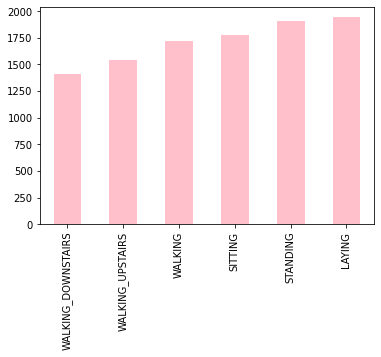

In [ ]:
class_count = len(data['Activity'].unique())
data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')

## Segmentação do Dataset

50% treino, 25% validação e 25% teste


In [ ]:
train, validate, test = \
              np.split(data.sample(frac=1, random_state=42), 
                       [int(.5*len(data)), int(.75*len(data))])
              
print(f'Shape of train data is {train.shape}')
print(f'Shape of validation data is {validate.shape}')
print(f'Shape of test data is {test.shape}')
validate.head()

Shape of train data is (5149, 563)
Shape of validation data is (2575, 563)
Shape of test data is (2575, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2117,0.274369,-0.016706,-0.110229,-0.991515,-0.989040,-0.978536,-0.992510,-0.990249,-0.980843,-0.936067,-0.561457,-0.812424,0.841441,0.691739,0.824627,-0.989752,-0.999926,-0.999935,-0.999490,-0.994133,-0.991564,-0.983694,-0.570835,-0.632256,-0.525435,0.194450,-0.146492,-0.041534,0.385220,0.146668,0.008702,0.117522,0.316987,0.049494,0.002990,0.077043,-0.040535,-0.326617,-0.124434,-0.467705,...,-1.000000,-1.000000,0.189798,-0.435028,-0.826468,-0.983336,-0.983446,-0.979036,-0.988786,-0.996133,-0.983336,-0.999768,-0.973804,-0.651509,-1.0,-0.200696,-0.692462,-0.925401,-0.990613,-0.989842,-0.989335,-0.990264,-0.995010,-0.990613,-0.999922,-0.988997,-0.923452,-1.000000,-0.165418,-0.227327,-0.592258,-0.031017,-0.068529,0.222656,-0.171256,0.365294,-0.846661,-0.004809,11,LAYING
2937,0.260018,-0.008491,-0.117588,-0.935685,-0.670521,-0.875247,-0.959882,-0.805597,-0.907493,-0.892596,-0.146449,-0.774665,0.710398,0.541556,0.691246,-0.910007,-0.997606,-0.978016,-0.991313,-0.995422,-0.989595,-0.963853,-0.310086,-0.398456,-0.248864,-0.508756,0.476951,-0.460860,0.392226,-0.604299,0.591770,-0.713939,0.839213,-0.252033,0.355529,-1.000000,1.000000,0.296486,-0.012320,-0.867214,...,-0.476360,-1.000000,-0.455206,0.384570,0.087227,-0.512505,-0.269562,-0.408939,-0.192944,-0.049099,-0.512505,-0.740628,-0.801698,0.130729,-1.0,-0.259452,0.265055,-0.064927,-0.929913,-0.863376,-0.907363,-0.843969,-0.985603,-0.929913,-0.993913,-0.935197,-0.419270,-1.000000,-0.563006,0.783258,0.551519,0.351286,0.079468,0.329166,0.006809,-0.885412,0.113755,0.100170,16,SITTING
6867,0.278964,-0.016177,-0.112617,-0.986395,-0.993402,-0.996253,-0.987809,-0.994375,-0.995559,-0.935219,-0.566172,-0.826331,0.838379,0.692073,0.845662,-0.992035,-0.999849,-0.999965,-0.999920,-0.989898,-0.995405,-0.992992,-0.391655,-0.668624,-0.735404,0.074098,-0.024003,-0.086759,-0.050424,0.497133,-0.308945,0.436123,-0.284634,0.562480,-0.303941,0.243113,-0.238292,-0.560531,-0.482763,0.529234,...,-1.000000,-0.746032,0.201563,-0.661723,-0.919496,-0.963026,-0.936948,-0.955237,-0.922671,-0.973526,-0.963026,-0.998002,-0.980297,-0.

## Preparando os Dados para os Modelos

*   **x** = Todos os conjuntos de dados tirando as duas ultimas colunas.
*   **y** = Ultima coluna, coluna que define a atividade.



In [ ]:
# Separando os os dados do target
x_train, y_train = train.iloc[:, :-2], train.iloc[:, -1:]
x_validate, y_validate = validate.iloc[:, :-2], validate.iloc[:, -1:]
x_test, y_test = test.iloc[:, :-2], test.iloc[:, -1:]
print(f'Train: {x_train.shape}, {y_train.shape}\nValidation: {x_validate.shape}, {y_validate.shape}\nTraining: {x_test.shape}, {y_test.shape}\n')

Train: (5149, 561), (5149, 1)
Validation: (2575, 561), (2575, 1)
Training: (2575, 561), (2575, 1)



Os modelos aceitam apenas números, então foi necessário alterar as strings que definem as classes para números.

In [ ]:
# Trasformando as strings do target em números
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validate = le.fit_transform(y_validate)
y_test = le.fit_transform(y_test)

# --------------Não sei oq é isso
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_validate = scaling_data.fit_transform(x_validate)
x_test = scaling_data.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Separando casos de teste do tipo LAYING

In [ ]:
test_laying = test[test.Activity == 'LAYING']
x_test_laying, y_test_laying = test_laying.iloc[:, :-2], test_laying.iloc[:, -1:]
y_test_laying = le.fit_transform(y_test_laying)
x_test_laying = scaling_data.fit_transform(x_test_laying)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def print_metrics(test_results):
    print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[4]}\nSpecificity: {test_results[5]}')

In [ ]:
def plot_loss(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(epochs)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_bar_graph(model_name, values, label, ord):
    plt.subplot(ord[0], ord[1], ord[2])
    plt.bar(model_name, values, color ='blue', width = 0.1)
    plt.xlabel("Models")
    plt.ylabel(label)
    plt.title("Comparing {} by models".format(label))

# Multi-Layer Perceptron (MLP)

Perceptron é utilizado para classificação binária, possuindo apenas 1 neurônio, sendo assim, não podendo se aplicar a dados não lineares. 
O MLP foi desenvolvido para suprir com essa limitação.Ele possui camadas de entrada e saída e uma ou mais camadas ocultas com muitos neurônios juntos. E enquanto no Perceptron o neurônio deve ter uma função de ativação que impõe um limite, como ReLU ou sigmoid, os neurônios em um MLP podem usar qualquer função de ativação arbitrária.

Funções de ativação: 
*   **ReLU**: Função não linear que a não ativa todos os neurônios ao mesmo tempo. Se a entrada for negativa, ela será convertida em zero e o neurônio não será ativado. Isso significa que, ao mesmo tempo, apenas alguns neurônios são ativados, tornando a rede esparsa e eficiente e fácil para a computação.
*   **Softmax**: Alternativa para função sigmóide para lidar com problemas de classificação, já que a mesma é capaz de lidar com mais de 2 classes, diferente da sigmóide.




In [ ]:
# Criando o model
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=x_train.shape[1])) # Layer 1
model_mlp.add(Dropout(0.25))
model_mlp.add(Dense(64, activation='relu')) # Layer 2
model_mlp.add(Dropout(0.25))
model_mlp.add(Dense(6, activation='softmax')) # Layer 3

# Dense = camada que recebe como entrada todos os neurônios da camada anterior. 
# Dropout = faz eliminacoes aleatorias de neuronios. Usado para diminuir over/underfitting



*   **Compilação, Treino e validação**: O processo de treino foi composto por 20 epocas e 50% do dataset e a validação por 25% do dataset. 
>* Optimizer: [**Adam**](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) é um algoritmo de otimização que pode ser usado em vez do procedimento clássico de *Stochastic Gradient Descent* (mantém uma única taxa de aprendizado para todas as atualizações de peso e a taxa de aprendizado não muda durante o treinamento) para atualizar os pesos da rede iterativos com base nos dados de treinamento.
>* Loss: [sparse_categorical_crossentropy](https://vitalflux.com/keras-categorical-cross-entropy-loss-function/) Usado para modelos de classificação multi-classes quando a output label  sao valores inteiros (0, 1, 2,..).


In [ ]:
# Compilando o model e treinando
model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 
                                                                                     keras_metrics.sparse_categorical_precision(), 
                                                                                     keras_metrics.sparse_categorical_recall(), 
                                                                                     keras_metrics.sparse_categorical_f1_score(), 
                                                                                     keras_metrics.sparse_categorical_true_negative()]) # optimizer 'adam'
history_mlp = model_mlp.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate)) # teinando e validando

# batch_size = número de exemplos de treinamento utilizados em uma iteração

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 2s 9ms/step - loss: 1.1004 - accuracy: 0.5333 - precision: 0.6928 - recall: 0.2273 - f1_score: 0.3244 - true_negative: 2065.7900 - val_loss: 0.6028 - val_accuracy: 0.8237 - val_precision: 0.8750 - val_recall: 0.5451 - val_f1_score: 0.6709 - val_true_negative: 5157.5854
Epoch 2/20
81/81 [==============================] - 0s 4ms/step - loss: 0.5792 - accuracy: 0.7671 - precision: 0.9071 - recall: 0.6879 - f1_score: 0.7820 - true_negative: 8235.7285 - val_loss: 0.3718 - val_accuracy: 0.8548 - val_precision: 0.9240 - val_recall: 0.7664 - val_f1_score: 0.8378 - val_true_negative: 11338.4395
Epoch 3/20
81/81 [==============================] - 0s 4ms/step - loss: 0.4094 - accuracy: 0.8361 - precision: 0.9332 - recall: 0.8134 - f1_score: 0.8691 - true_negative: 14424.5801 - val_loss: 0.2963 - val_accuracy: 0.8835 - val_precision: 0.9410 - val_recall: 0.8445 - val_f1_score: 0.8901 - val_true_negative: 17543.7324
Epoch 4/20
81/81 [========================

Testando o modelo com dataset de teste que equivale 50% do dataset total

In [ ]:
# Testa o treino com todas as classes
all_results_mlp = model_mlp.evaluate(x_test, y_test, verbose=1)
print_metrics(all_results_mlp)

81/81 [==============================] - 0s 2ms/step - loss: 0.1099 - accuracy: 0.9616 - precision: 0.9849 - recall: 0.9753 - f1_score: 0.9801 - true_negative: 125754.3125
Loss: 0.10985103994607925
Accuracy: 0.9615533947944641
Precision: 0.9849181771278381
Recall: 0.9753333926200867
F1 Score: 0.9801021814346313
Specificity: 125754.3125


In [ ]:
# Testa o treino apenas com a classe LAYING
laying_results_mlp = model_mlp.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_mlp)

15/15 [==============================] - 0s 2ms/step - loss: 0.3886 - accuracy: 0.9034 - precision: 0.9852 - recall: 0.9749 - f1_score: 0.9800 - true_negative: 126777.0000
Loss: 0.3885659873485565
Accuracy: 0.9033613204956055
Precision: 0.9851570129394531
Recall: 0.9749115705490112
F1 Score: 0.9800072908401489
Specificity: 126777.0


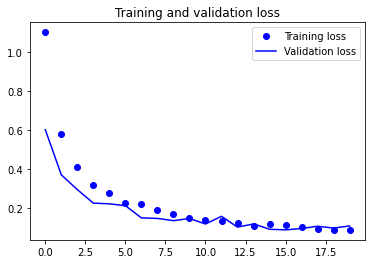

In [ ]:
plot_loss(history_mlp, 20)

# Convolutional Neural Network (CNN)
Uma **Artificial Neural Network (ANN)** é uma série de algoritmos que se esforçam para reconhecer relacionamentos subjacentes em um conjunto de dados, por meio de um processo que imita a maneira como o cérebro humano opera. As **ANN** podem se adaptar a mudanças de entrada para que a rede gere o melhor resultado possível sem a necessidade de redesenhar os critérios de saída.

As **Convolutional Neural Network (CNN)** são um tipo especializado de ANN que usam convolução no lugar da multiplicação geral da matriz em pelo menos uma de suas camadas.

In [ ]:
n_timesteps, n_features, n_outputs = x_train.shape[0], x_train.shape[1], y_train.shape[0]

# Adicionando mais uma dimensão a x, para ficarem 3, como é pedido no Conv1D
x_train_cnn = x_train[..., None]
x_validate_cnn = x_validate[..., None]

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=x_train_cnn.shape[1:]))
model_cnn.add(Dropout(0.2))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu')) # filters = quantas janelas diferentes com o mesmo comprimento | kernel_size = define o tamanho da janela deslizante
model_cnn.add(Dropout(0.2))
model_cnn.add(MaxPooling1D(pool_size=2)) # tamanho da janela de max pooling
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten()) # agrupa features map em uma coluna
model_cnn.add(Dense(10, activation='softmax'))
 
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',
                                                                                     keras_metrics.sparse_categorical_precision(), 
                                                                                     keras_metrics.sparse_categorical_recall(), 
                                                                                     keras_metrics.sparse_categorical_f1_score(), 
                                                                                     keras_metrics.sparse_categorical_true_negative()])
history_cnn = model_cnn.fit(x_train_cnn, y_train, batch_size=64, epochs=20, validation_data=(x_validate_cnn, y_validate))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 14s 163ms/step - loss: 0.7495 - accuracy: 0.6865 - precision: 0.6690 - recall: 0.3760 - f1_score: 0.4721 - true_negative: 2075.8025 - val_loss: 0.3210 - val_accuracy: 0.8920 - val_precision: 0.9354 - val_recall: 0.7390 - val_f1_score: 0.8255 - val_true_negative: 5190.3901
Epoch 2/20
81/81 [==============================] - 13s 155ms/step - loss: 0.2539 - accuracy: 0.9037 - precision: 0.9571 - recall: 0.8340 - f1_score: 0.8912 - true_negative: 8270.5684 - val_loss: 0.3022 - val_accuracy: 0.8835 - val_precision: 0.9683 - val_recall: 0.8776 - val_f1_score: 0.9207 - val_true_negative: 11431.1709
Epoch 3/20
81/81 [==============================] - 13s 156ms/step - loss: 0.1653 - accuracy: 0.9369 - precision: 0.9737 - recall: 0.9031 - f1_score: 0.9371 - true_negative: 14533.1113 - val_loss: 0.1854 - val_accuracy: 0.9313 - val_precision: 0.9783 - val_recall: 0.9196 - val_f1_score: 0.9480 - val_true_negative: 17679.7812
Epoch 4/20
81/81 [===============

In [ ]:
# Testando o model após treinamento
x_test_cnn = x_test[..., None]
all_results_cnn = model_cnn.evaluate(x_test, y_test, verbose=1)
print_metrics(all_results_cnn)

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 2s 15ms/step - loss: 0.0968 - accuracy: 0.9662 - precision: 0.9962 - recall: 0.9885 - f1_score: 0.9923 - true_negative: 126083.3125
Loss: 0.09682712703943253
Accuracy: 0.966213583946228
Precision: 0.9961521625518799
Recall: 0.9885116219520569
F1 Score: 0.9923171997070312
Specificity: 126083.3125


In [ ]:
# Testa o treino apenas com a classe LAYING
laying_results_cnn = model_cnn.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_cnn)

15/15 [==============================] - 0s 16ms/step - loss: 0.4577 - accuracy: 0.9391 - precision: 0.9962 - recall: 0.9883 - f1_score: 0.9922 - true_negative: 127106.0000
Loss: 0.4577447772026062
Accuracy: 0.9390756487846375
Precision: 0.9962145686149597
Recall: 0.9882500767707825
F1 Score: 0.992216169834137
Specificity: 127106.0


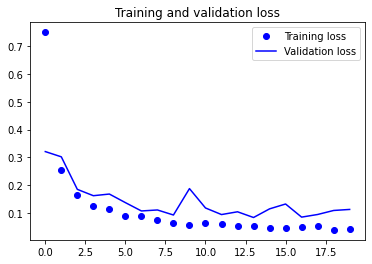

In [ ]:
plot_loss(history_cnn, 20)

# Recurrent Neural Network (RNN)

**Recurrent Neural Network (RNN)** tem uma conexão recorrente no *hidden state*. Essa restrição de loop garante que as informações sequenciais sejam capturadas nos dados de entrada.

In [ ]:
x_train_rnn = x_train[..., None]
x_validate_rnn = x_validate[..., None]

model_rnn2 = keras.models.Sequential()
model_rnn2.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_rnn2.add(layers.SimpleRNN(128, return_sequences=True, activation='relu')) # dimensionalidade do espaço de saída | return_sequences=True
model_rnn2.add(Dropout(0.2))
model_rnn2.add(Flatten())
model_rnn2.add(layers.Dense(10))

model_rnn2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 561, 128)          16640     
                                                                 
 dropout_23 (Dropout)        (None, 561, 128)          0         
                                                                 
 flatten_6 (Flatten)         (None, 71808)             0         
                                                                 
 dense_26 (Dense)            (None, 10)                718090    
                                                                 
Total params: 734,730
Trainable params: 734,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy", 
            keras_metrics.sparse_categorical_precision(), 
            keras_metrics.sparse_categorical_recall(), 
            keras_metrics.sparse_categorical_f1_score(), 
            keras_metrics.sparse_categorical_true_negative()]

model_rnn2.compile(loss=loss, optimizer=optim, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_rnn2 = model_rnn2.fit(
    x_train_rnn, y_train, validation_data=(x_validate_rnn, y_validate), batch_size=64, epochs=10
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 27s 314ms/step - loss: 0.4358 - accuracy: 0.8167 - precision: 1.3982 - recall: 6.9615 - f1_score: 2.2754 - true_negative: 3629.4075 - val_loss: 0.2310 - val_accuracy: 0.9017 - val_precision: 4.2638 - val_recall: 10.1211 - val_f1_score: 5.9906 - val_true_negative: 14884.6338
Epoch 2/10
81/81 [==============================] - 25s 308ms/step - loss: 0.1218 - accuracy: 0.9518 - precision: 4.4623 - recall: 11.0976 - f1_score: 30.0529 - true_negative: 29375.6172 - val_loss: 0.1224 - val_accuracy: 0.9515 - val_precision: -6.7462 - val_recall: 11.8538 - val_f1_score: -52.6657 - val_true_negative: 48799.4648
Epoch 3/10
81/81 [==============================] - 25s 313ms/step - loss: 0.0754 - accuracy: 0.9707 - precision: -3.2843 - recall: 12.4147 - f1_score: -9.0872 - true_negative: 70965.0391 - val_loss: 0.1054 - val_accuracy: 0.9600 - val_precision: -2.5848 - val_recall: 12.9876 - val_f1_score: -6.4572 - val_true_negative: 93032.9766
Epoch 4/10
81/81 [

In [ ]:
all_results_rnn = model_rnn2.evaluate(x_test, y_test, batch_size=64, verbose=2)
print_metrics(all_results_rnn)

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


41/41 - 4s - loss: 0.0720 - accuracy: 0.9744 - precision: -1.0211e+00 - recall: 15.8831 - f1_score: -2.1826e+00 - true_negative: 532783.3125 - 4s/epoch - 89ms/step
Loss: 0.07202666252851486
Accuracy: 0.9743689298629761
Precision: -1.0211200714111328
Recall: 15.883074760437012
F1 Score: -2.1825625896453857
Specificity: 532783.3125


In [ ]:
# Testa o treino apenas com a classe LAYING
laying_results_rnn = model_rnn2.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_rnn)

15/15 [==============================] - 1s 52ms/step - loss: 0.8490 - accuracy: 0.8025 - precision: -1.0423 - recall: 15.8728 - f1_score: -2.2312 - true_negative: 543995.0000
Loss: 0.8489676117897034
Accuracy: 0.8025209903717041
Precision: -1.0423343181610107
Recall: 15.872782707214355
F1 Score: -2.231231212615967
Specificity: 543995.0


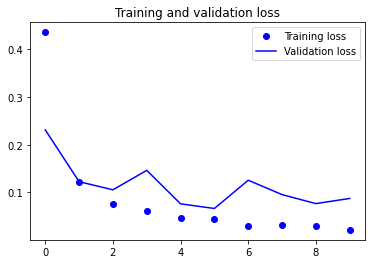

In [ ]:
plot_loss(history_rnn2, 10)

# Modelo Híbrido
Criando modelo híbrido

In [ ]:
x_train = x_train[..., None]
x_validate = x_validate[..., None]

model_hyb = Sequential()
# Model RNN
model_hyb.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_hyb.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
# Model CNN
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Dropout(0.2))
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Dropout(0.2))
model_hyb.add(MaxPooling1D(pool_size=2))
model_hyb.add(Dropout(0.2))
model_hyb.add(Flatten())
# Model MLP
model_hyb.add(Dense(64, activation='relu')) # Layer 1
model_hyb.add(Dropout(0.2))
model_hyb.add(Dense(64, activation='relu')) # Layer 2
model_hyb.add(Dropout(0.2))
model_hyb.add(Dense(10, activation='softmax'))

model_hyb.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 561, 128)          16640     
                                                                 
 conv1d_11 (Conv1D)          (None, 560, 64)           16448     
                                                                 
 dropout_24 (Dropout)        (None, 560, 64)           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 559, 64)           8256      
                                                                 
 dropout_25 (Dropout)        (None, 559, 64)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 279, 64)          0         
 1D)                                                             
                                                     

In [ ]:
model_hyb.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',
                                                                                      keras_metrics.sparse_categorical_precision(), 
                                                                                      keras_metrics.sparse_categorical_recall(), 
                                                                                      keras_metrics.sparse_categorical_f1_score(), 
                                                                                      keras_metrics.sparse_categorical_true_negative()])
history = model_hyb.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 42s 495ms/step - loss: 0.9866 - accuracy: 0.5655 - precision: 0.5607 - recall: 0.3109 - f1_score: 0.3914 - true_negative: 2003.5802 - val_loss: 0.3136 - val_accuracy: 0.8858 - val_precision: 0.8547 - val_recall: 0.6618 - val_f1_score: 0.7459 - val_true_negative: 5115.7559
Epoch 2/20
81/81 [==============================] - 40s 493ms/step - loss: 0.3093 - accuracy: 0.8749 - precision: 0.9123 - recall: 0.7815 - f1_score: 0.8417 - true_negative: 8215.7041 - val_loss: 0.2208 - val_accuracy: 0.9076 - val_precision: 0.9382 - val_recall: 0.8399 - val_f1_score: 0.8863 - val_true_negative: 11359.4395
Epoch 3/20
81/81 [==============================] - 40s 493ms/step - loss: 0.2012 - accuracy: 0.9241 - precision: 0.9493 - recall: 0.8723 - f1_score: 0.9091 - true_negative: 14458.7412 - val_loss: 0.1247 - val_accuracy: 0.9522 - val_precision: 0.9574 - val_recall: 0.8938 - val_f1_score: 0.9245 - val_true_negative: 17598.8301
Epoch 4/20
81/81 [===============

In [ ]:
# Testando o model após treinamento
x_test_rnn2 = x_test[..., None]
all_results_hyb = model_hyb.evaluate(x_test_rnn2, y_test, verbose=1)
print_metrics(all_results_hyb)

81/81 [==============================] - 6s 73ms/step - loss: 0.0868 - accuracy: 0.9740 - precision: 0.9924 - recall: 0.9837 - f1_score: 0.9880 - true_negative: 125972.3125
Loss: 0.0867949053645134
Accuracy: 0.9739806056022644
Precision: 0.9923648834228516
Recall: 0.9837474226951599
F1 Score: 0.9880369901657104
Specificity: 125972.3125


In [ ]:
# Testa o treino apenas com a classe LAYING
laying_results_hyb = model_hyb.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_hyb)

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


15/15 [==============================] - 2s 72ms/step - loss: 0.4876 - accuracy: 0.9328 - precision: 0.9925 - recall: 0.9835 - f1_score: 0.9880 - true_negative: 126995.0000
Loss: 0.48757678270339966
Accuracy: 0.9327731132507324
Precision: 0.9924878478050232
Recall: 0.9834827780723572
F1 Score: 0.9879647493362427
Specificity: 126995.0


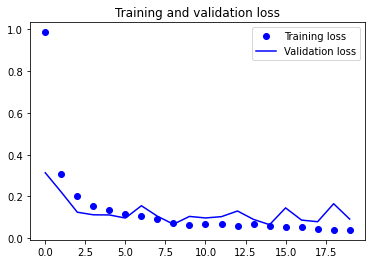

In [ ]:
plot_loss(history, 20)

# Dados

In [ ]:
loss = {
  'MLP': laying_results_mlp[0], 
  'CNN': laying_results_cnn[0], 
  'RNN': laying_results_rnn[0], 
  'Hybrid': laying_results_hyb[0]
}
accuracy = {
    'MLP': laying_results_mlp[1], 
    'CNN': laying_results_cnn[1], 
    'RNN': laying_results_rnn[1], 
    'Hybrid': laying_results_hyb[1]
}

precision = {
    'MLP': laying_results_mlp[2], 
    'CNN': laying_results_cnn[2], 
    'RNN': laying_results_rnn[2], 
    'Hybrid': laying_results_hyb[2]
}

recall = {
    'MLP': laying_results_mlp[3], 
    'CNN': laying_results_cnn[3], 
    'RNN': laying_results_rnn[3], 
    'Hybrid': laying_results_hyb[3]
}

f1_score = {
    'MLP': laying_results_mlp[4], 
    'CNN': laying_results_cnn[4], 
    'RNN': laying_results_rnn[4], 
    'Hybrid': laying_results_hyb[4]
}

specificity = {
    'MLP': laying_results_mlp[5], 
    'CNN': laying_results_cnn[5], 
    'RNN': laying_results_rnn[5], 
    'Hybrid': laying_results_hyb[5]
}

# Conclusão

Para analisar e comparar os resultados obtidos, plotamos os graficos que compara os modelos pelas metricas:


* Accuracy: 

  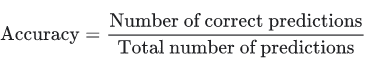
* Precision: Qual proporção de identificações positivas estava realmente correta? 

    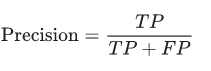


* Recall: What proportion of actual positives was identified correctly?

  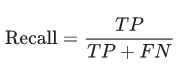
* F1 Score: 

    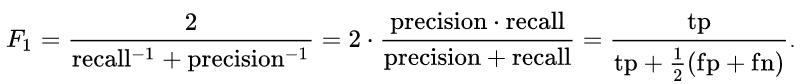
    
* Specificity: 

    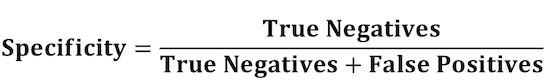


  *TP = Verdadeiros positivos* 
      
  *FP = Falsos positivos*

  *FN = Falsos negativos*



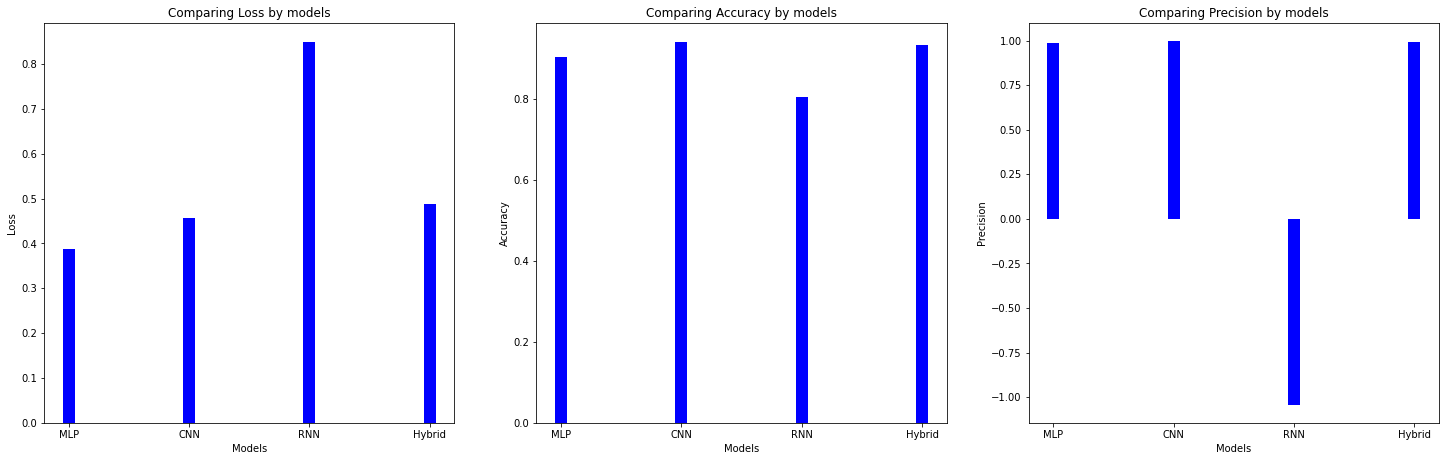

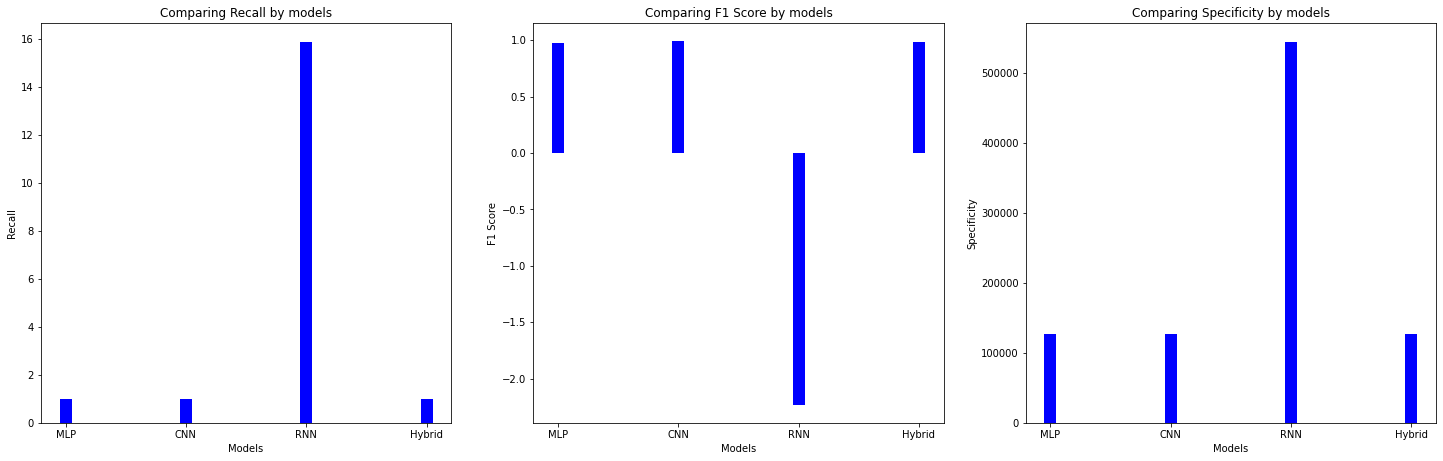

In [ ]:
plt.figure(figsize=(25, 25))
plot_bar_graph(list(loss.keys()), list(loss.values()), "Loss", [3, 3, 1])
plot_bar_graph(list(accuracy.keys()), list(accuracy.values()), "Accuracy",  [3, 3, 2])
plot_bar_graph(list(precision.keys()), list(precision.values()), "Precision",  [3, 3, 3])
plt.show()
plt.figure(figsize=(25, 25))
plot_bar_graph(list(recall.keys()), list(recall.values()), "Recall",  [3, 3, 1])
plot_bar_graph(list(f1_score.keys()), list(f1_score.values()), "F1 Score",  [3, 3, 2])
plot_bar_graph(list(specificity.keys()), list(specificity.values()), "Specificity",  [3, 3, 3])
plt.show()

Com a analise dos graficos foi possivel identificar que o modelo **hybrid** obteve o melhor desempelho comparado com os outros modelos, mesmo comparada com a MLP, tecnica especifica para tratar de dados tabular, porem essa tecnica tem series de deficits, como Recurrent connections, Parameter sharing e Spatial relationship.

Tecnicas que são encontradas nos outros modelos, o que faz o hybrid o melhor modelo, ja que o deficie do MLP é suprido pelo RNN e CNN. 

![image.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/table.png)